In [177]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [178]:
quandl.ApiConfig.api_key = 'sARpTygXxsbkQoM8sKn4'

stocks = ['MU','WDC','3690.HK','UA','MRK', 'NOVN.SW']

min_weight = 0.1
max_weight = 0.2

num_portfolios = 100000
risk_free_rate = 0.0221

In [179]:
import yfinance as yf
from datetime import datetime

start = datetime(2019, 1, 1)
end = datetime(2019, 7, 2)

# portfolio stocks
stocks = ['MU','WDC','3690.HK','UA','MRK', 'NOVN.SW']

table = yf.download(stocks, start=start, end=end)
table = table['Close'].dropna()

table.shape

[*********************100%***********************]  6 of 6 downloaded


(113, 6)

Text(0, 0.5, 'price in $')

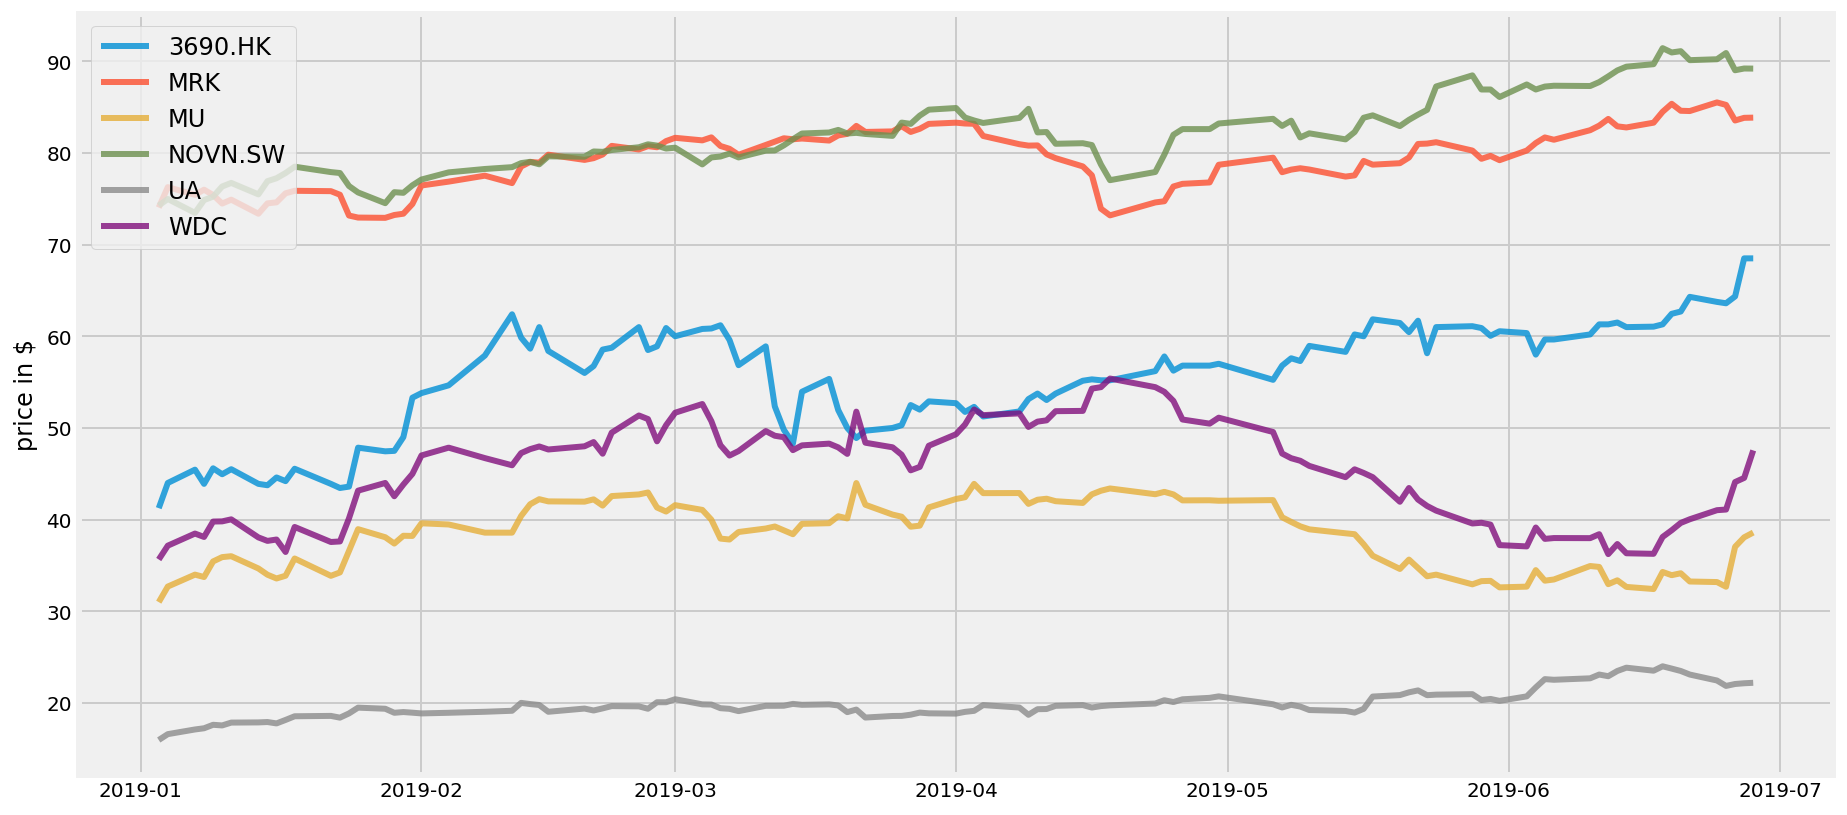

In [180]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

(113, 6)

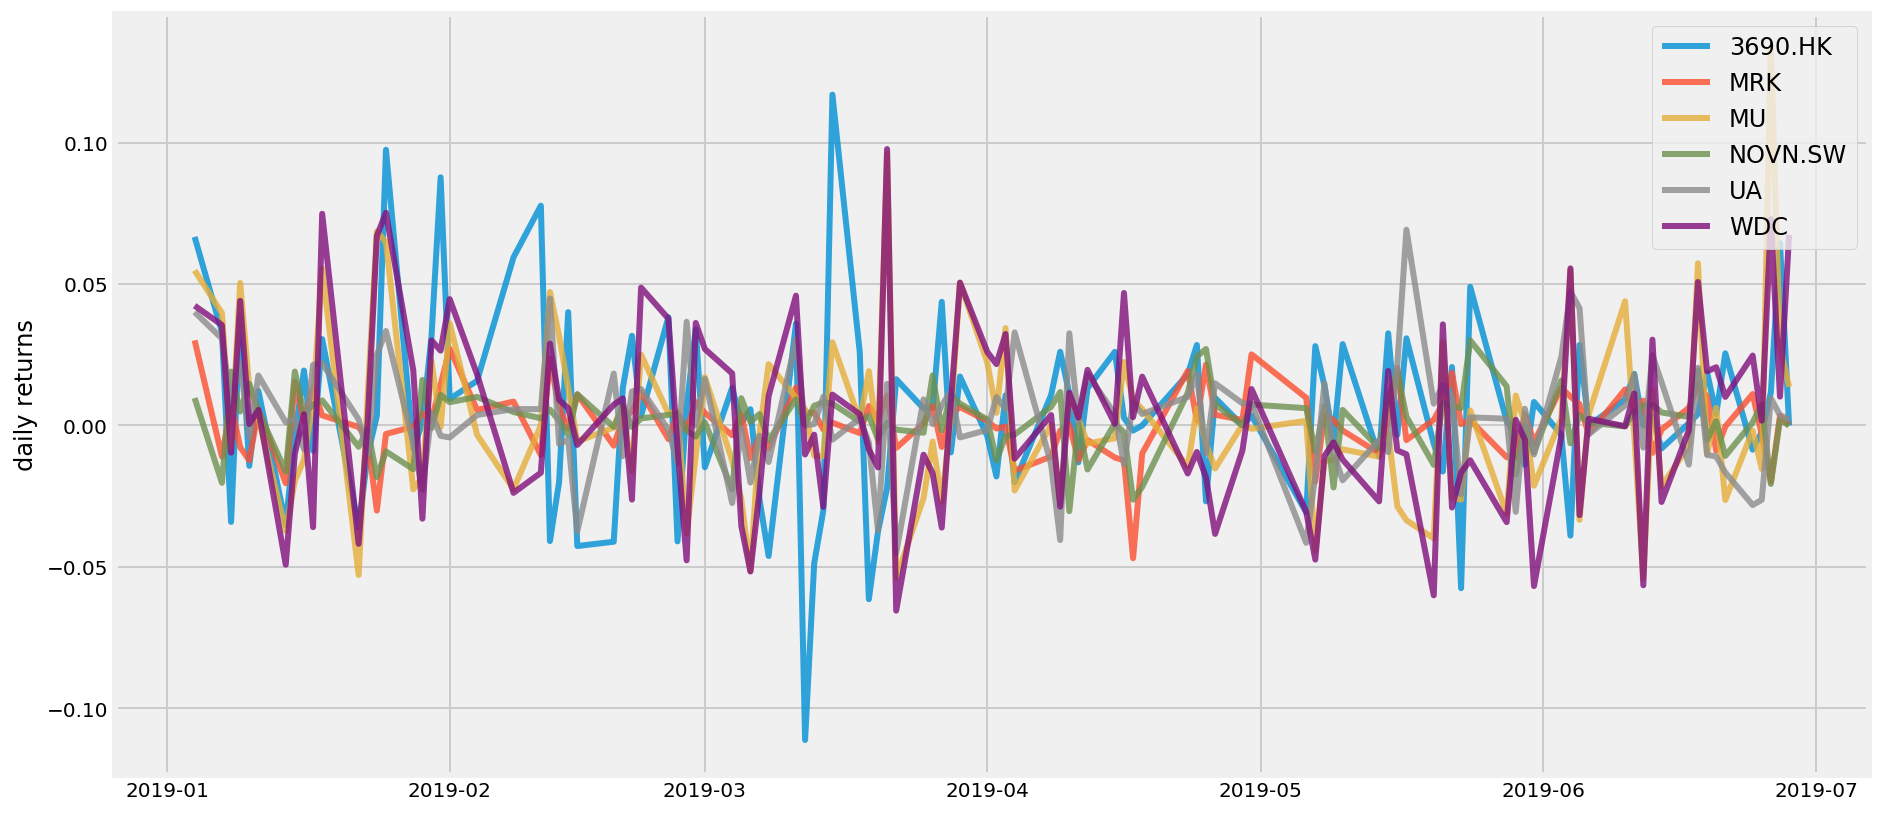

In [181]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

returns.shape

In [182]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        # min and max allocation and num of stock
        weights = np.random.uniform(min_weight, max_weight, len(stocks))
        
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    print(results.shape)
    print(len(weights_record))
    return results, weights_record

In [183]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

print(returns.shape)
print(cov_matrix.shape)
print(returns.shape)

(113, 6)
(6, 6)
(113, 6)


In [184]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("--------")
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("---------")
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

(3, 100000)
100000
--------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.69
Annualised Volatility: 0.19


            3690.HK    MRK     MU  NOVN.SW     UA    WDC
allocation    17.97  18.16  10.71    20.89  20.85  11.41
---------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.63
Annualised Volatility: 0.18


            3690.HK    MRK     MU  NOVN.SW     UA    WDC
allocation    11.37  22.45  11.65    22.35  19.53  12.66


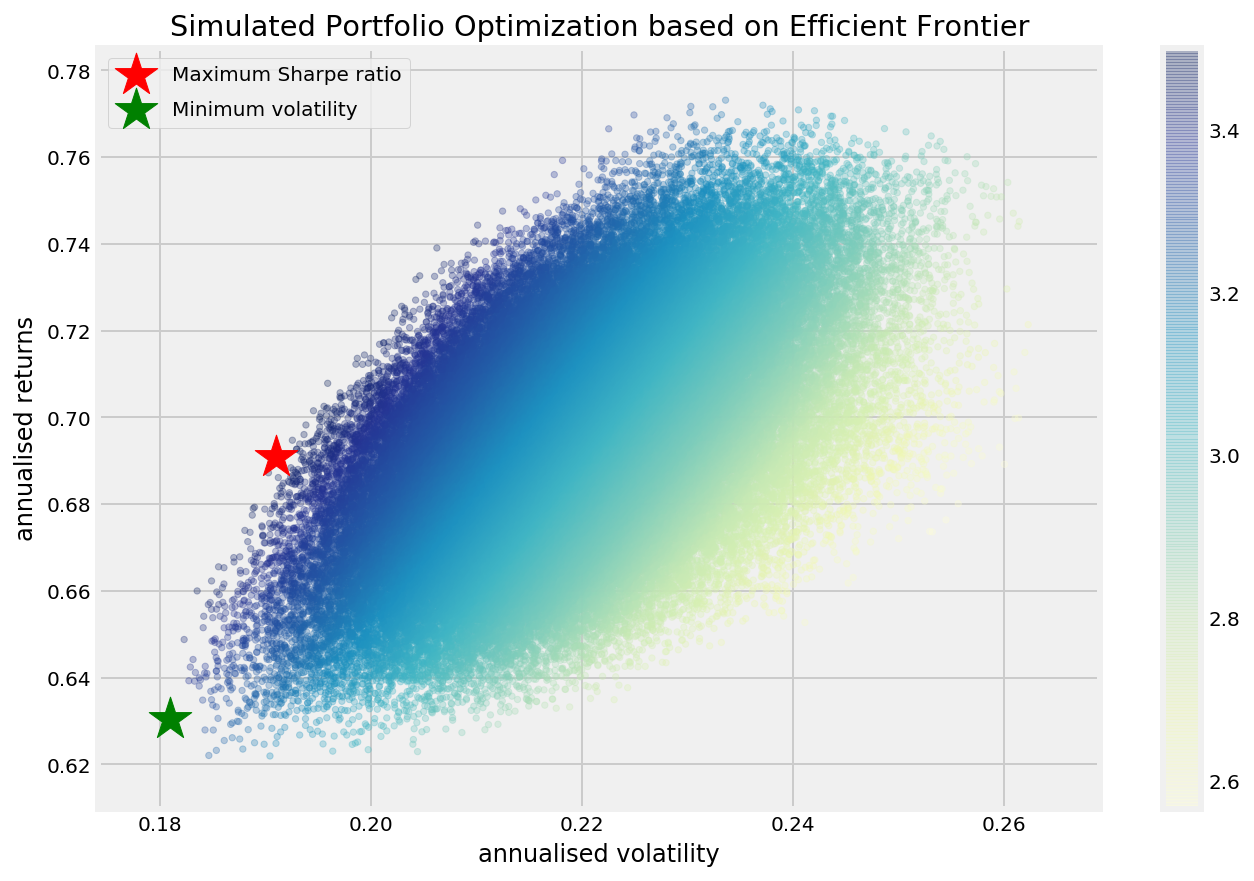

In [185]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)